In [5]:
import xarray as xr
import pandas as pd
import os

# Folder containing NetCDF files
folder_path = "/home/pcuser/titanlib/notebooks/nebelhorn"

# Define the timestamp you want to compare
target_time = "2024-01-10T10:00:00"  # Change as needed

# List to store data from each file
data_list = []

# Loop through all NetCDF files in the folder
for file in os.listdir(folder_path):
    if file.endswith(".nc"):
        file_path = os.path.join(folder_path, file)
        
        # Open the NetCDF file
        ds = xr.open_dataset(file_path)
        
        # Extract station name (assuming it's in the filename or attributes)
        station_name = file.split(".nc")[0]  # Modify if needed
        
        # Extract the nearest available time to the target time
        ds = ds.sel(time=pd.to_datetime(target_time), method="nearest")
        
        # Extract relevant variables (modify based on your data)
        temp = ds.get("temperature", None)
        wind_speed = ds.get("wind_speed", None)
        pressure = ds.get("pressure", None)
        
        # Store extracted data
        data_list.append({
            "Station": station_name,
            "Time": str(ds.time.values),
            "Temperature": float(temp.values) if temp is not None else None,
            "Wind Speed": float(wind_speed.values) if wind_speed is not None else None,
            "Pressure": float(pressure.values) if pressure is not None else None
        })
        
        ds.close()

# Convert to Pandas DataFrame for easy comparison
df = pd.DataFrame(data_list)

# Display the DataFrame
print(df)

# Optionally, save to CSV
df.to_csv("weather_comparison.csv", index=False)


              Station                           Time Temperature  Wind Speed  \
0     nebelhorn-pit_3  2024-01-10T10:00:00.000000000        None         NaN   
1   nebelhorn-pit_116  2024-01-10T10:00:00.000000000        None         NaN   
2   nebelhorn-pit_305  2024-01-10T10:00:00.000000000        None         NaN   
3   nebelhorn-pit_209  2024-01-10T10:00:00.000000000        None         NaN   
4   nebelhorn-pit_119  2024-01-10T10:00:00.000000000        None         NaN   
..                ...                            ...         ...         ...   
89  nebelhorn-pit_611  2024-01-10T10:00:00.000000000        None         NaN   
90  nebelhorn-pit_213  2024-01-10T10:00:00.000000000        None         NaN   
91           dwd_3730  2024-01-10T10:00:00.000000000        None         2.0   
92  nebelhorn-pit_101  2024-01-10T10:00:00.000000000        None         NaN   
93  nebelhorn-pit_306  2024-01-10T10:00:00.000000000        None         NaN   

   Pressure  
0      None  
1      None

In [6]:
# Define winter months again (Northern Hemisphere: December, January, February)
winter_months = [12, 1, 2]

# Define a function to find the first available winter daytime timestamp
def get_winter_daytime_timestamp(time_values):
    # Convert to pandas datetime
    time_values = pd.to_datetime(time_values)
    # Filter for winter months and daytime hours (12:00 - 15:00)
    winter_times = [t for t in time_values if t.month in winter_months and 12 <= t.hour <= 15]
    # Return the first available timestamp if any exist
    return winter_times[0] if winter_times else None

# List to store extracted data
data_list = []

# Loop through all NetCDF files in the folder
for file in os.listdir(folder_path):
    if file.endswith(".nc"):
        file_path = os.path.join(folder_path, file)
        
        # Open the NetCDF file
        ds = xr.open_dataset(file_path)
        
        # Extract station name (assuming it's in the filename)
        station_name = file.split(".nc")[0]
        
        # Find the first available winter daytime timestamp
        selected_time = get_winter_daytime_timestamp(ds["time"].values)
        
        if selected_time:
            # Select the nearest available time
            ds_sel = ds.sel(time=selected_time, method="nearest")

            # Extract relevant variables
            temp = ds_sel["temp"].values.item() if "temp" in ds_sel else None
            rel_hum = ds_sel["rel_hum"].values.item() if "rel_hum" in ds_sel else None
            lon = ds_sel["lon"].values.item() if "lon" in ds_sel else None
            lat = ds_sel["lat"].values.item() if "lat" in ds_sel else None
            alt = ds_sel["alt"].values.item() if "alt" in ds_sel else None

            # Append to list
            data_list.append({
                "Station": station_name,
                "Time": str(ds_sel.time.values),
                "Temperature": temp,
                "Relative Humidity": rel_hum,
                "Longitude": lon,
                "Latitude": lat,
                "Altitude": alt,
            })

        # Close dataset
        ds.close()

# Convert to Pandas DataFrame for easy comparison
df = pd.DataFrame(data_list)

# Display DataFrame
df.head()


,Station,Time,Temperature,Relative Humidity,Longitude,Latitude,Altitude
0,nebelhorn-pit_3,2019-12-01T12:00:00.000000000,NaN,NaN,10.315118,47.409702,1335.480957
1,nebelhorn-pit_116,2019-12-01T12:00:00.000000000,273.083333,98.725000,10.296711,47.410301,1025.077026
2,nebelhorn-pit_305,2019-12-01T12:00:00.000000000,NaN,NaN,10.345387,47.412685,1911.375977
3,nebelhorn-pit_209,2019-12-01T12:00:00.000000000,NaN,NaN,10.326666,47.408394,1395.333008
4,nebelhorn-pit_119,2019-12-01T12:00:00.000000000,273.483333,98.291667,10.295107,47.408539,976.849976


In [7]:
import titanlib

# Extract the relevant columns
latitude = df['Latitude'].values
longitude = df['Longitude'].values
altitude = df['Altitude'].values
temperature = df['Temperature'].values  # Observations (e.g., temperature)

# Create TitanLib Points object
points = titanlib.Points(latitude, longitude, altitude, temperature)
flags = titanlib.metadata_check(
    points, True, True, True, True
)

print(flags)

[1 0 1 1 0 1 1 1 0 0 0 0 1 1 0 1 0 0 1 0 1 1 1 0 1 0 0 0 0 0 1 0 0 0 0 1 0
 0 1 0 0 1 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 1 1 0 0
 1 0 0 1 1 0 0 0 0 1 0 1 0 0 1 0 0 0 0 1]


/tmp/ipykernel_2333/2560626354.py:15: DeprecationWarning: numpy.core.arrayprint is deprecated and has been renamed to numpy._core.arrayprint. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.arrayprint._default_array_str.
  print(flags)


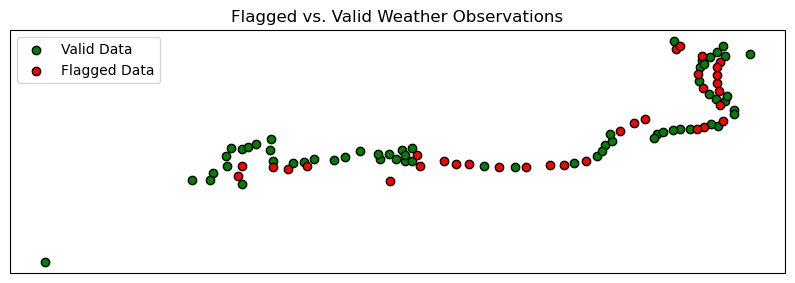

In [8]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# Extract flagged and unflagged indices
flagged_indices = np.where(flags != 0)[0]  # Flags that are not 0 (invalid)
unflagged_indices = np.where(flags == 0)[0]  # Valid data points

# Create a map
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={"projection": ccrs.PlateCarree()})

# Add map features
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.add_feature(cfeature.COASTLINE)

# Plot valid observations (green)
ax.scatter(
    longitude[unflagged_indices], latitude[unflagged_indices],
    c="green", label="Valid Data", edgecolors="black", transform=ccrs.PlateCarree()
)

# Plot flagged observations (red)
ax.scatter(
    longitude[flagged_indices], latitude[flagged_indices],
    c="red", label="Flagged Data", edgecolors="black", transform=ccrs.PlateCarree()
)

# Add title & legend
ax.set_title("Flagged vs. Valid Weather Observations")
ax.legend()

# Show the map
plt.show()


In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.show()

In [9]:
filtered_df = df[flags == 1]

print(filtered_df)

KeyError: "None of [Index([ True, False,  True,  True, False,  True,  True,  True, False, False,\n       False, False,  True,  True, False,  True, False, False,  True, False,\n        True,  True,  True, False,  True, False, False, False, False, False,\n        True, False, False, False, False,  True, False, False,  True, False,\n       False,  True,  True, False, False, False,  True, False, False, False,\n        True, False, False, False, False, False, False, False, False, False,\n       False, False,  True, False, False,  True, False, False,  True, False,\n        True,  True, False, False,  True, False, False,  True,  True, False,\n       False, False, False,  True, False,  True, False, False,  True, False,\n       False, False, False,  True],\n      dtype='bool')] are in the [columns]"

In [13]:
# Check number of rows in the DataFrame
print(len(df))

# Check the length of flags
print(len(flags))


94
94


In [15]:
print(flags == 1)  # Check the boolean array generated by flags == 1
print(df.shape)    # Check the shape of the DataFrame



[ True False  True  True False  True  True  True False False False False
  True  True False  True False False  True False  True  True  True False
  True False False False False False  True False False False False  True
 False False  True False False  True  True False False False  True False
 False False  True False False False False False False False False False
 False False  True False False  True False False  True False  True  True
 False False  True False False  True  True False False False False  True
 False  True False False  True False False False False  True]
(94, 7)


In [ ]:
print(df.columns.tolist())
print(df.head())
print(np.isnan(flags).any())



In [1]:
import pandas as pd
import numpy as np

# Minimal DataFrame
df = pd.DataFrame({
    'A': [1, 2, 3],
    'B': [4, 5, 6]
})

# Minimal flags array
flags = np.array([1, 0, 1])

# Attempt filtering
filtered_df = df[flags == 1]
print(filtered_df)


   A  B
0  1  4
2  3  6
